# Import library & function

In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import seaborn as sns
import keras.backend as K

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from prettytable import PrettyTable
from matplotlib.ticker import FuncFormatter 
from keras.models import model_from_json
from sklearn import preprocessing
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
pd.set_option('display.max_rows', 10)
sns.set(font_scale=1.4)

# Read pre-processed data

<font size="3">
There are 13 candidate inputs, 8 measured data and 5 extracted data, for split-type air conditioner power baseline modeling.
<br>
The split-type air conditioner power consumption is defined as a target for training the supervised learning.
</font>

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/baseline_modeling.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'],dayfirst=True)
df.index = df['DateTime']
df = df.dropna()
df = df.drop(['DateTime'],axis=1)
df

,Clock hour,Week number,Day of week,Type of day,Month,Dry bulb temperature,Wet bulb temperature,Dew point temperature,Solar irradiance,Ambient temperature,Relative humidity,UV index,Wind speed,Target
DateTime,,,,,,,,,,,,,,
2018-03-12 22:00:00,22,11,1,1,3,27.9,24.9,23.5,3.20,31.690,56.033000,0.00,2.260,0.0
2018-03-12 23:00:00,23,11,1,1,3,27.9,25.4,24.1,2.50,31.280,56.351333,0.00,2.840,0.0
2018-03-13 00:00:00,0,11,2,1,3,27.6,25.6,24.7,0.00,27.970,63.188333,0.00,2.064,0.0
2018-03-13 01:00:00,1,11,2,1,3,27.3,25.7,25.3,0.00,27.784,64.176667,0.00,1.530,0.0
2018-03-13 02:00:00,2,11,2,1,3,27.3,25.7,25.2,0.00,27.662,64.775000,0.00,1.480,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00,18,53,1,0,12,27.9,22.1,18.9,6.35,27.580,59.574333,0.00,4.835,0.0
2018-12-31 19:00:00,19,53,1,0,12,27.0,21.8,18.9,4.75,27.240,59.272333,0.00,3.065,0.0
2018-12-31 20:00:00,20,53,1,0,12,26.4,21.8,19.7,6.05,26.860,59.010167,0.00,4.210,0.0


# Input selection

<font size="3">
There are two-type of input selection techniques including Pearson's correlation coefficient and Random forest.
</font>

In [4]:
# Pearson correlation
pearson = df.corr(method='pearson')
pd.set_option('display.max_rows', 13)
input_selection_pearson = pd.Series(pearson['Target']*100, index=pearson.columns[:-1]).sort_values(ascending=False).to_frame()
input_selection_pearson = input_selection_pearson.rename(columns={"Target": "Importance (%)"})
round(input_selection_pearson,2)

,Importance (%)
Type of day,51.61
Solar irradiance,42.18
UV index,35.74
Dry bulb temperature,35.71
Wind speed,34.50
Ambient temperature,25.35
Wet bulb temperature,13.83
Clock hour,11.75
Week number,2.65
Month,1.60


In [5]:
# Random forest

np.random.seed(0)
array = df.values
model = ExtraTreesRegressor(n_estimators=100)
model.fit(array[:,0:-1], np.ravel(df.values[:,-1:]))
pd.set_option('display.max_rows', 15)
input_selection_random_forest = pd.Series(model.feature_importances_*100, index=df.columns[:-1]).sort_values(ascending=False).to_frame()
input_selection_random_forest = input_selection_random_forest.rename(columns={0: "Importance (%)"})
round(input_selection_random_forest,2)

,Importance (%)
Type of day,28.19
Solar irradiance,25.45
Clock hour,16.58
UV index,10.24
Dry bulb temperature,4.24
Wind speed,2.52
Week number,2.42
Ambient temperature,2.34
Day of week,1.74
Dew point temperature,1.72


# Normalization

<font size="3">
Normalize features and target to the range 0 to 1 using min-max normalization. The min-max normalization can be described by
<br>
<br>
$x_{normalized}=\frac{x-x_{min}}{x_{max}-x{min}}$
<br>
<br>
where $x_{min}$ and $x_{max}$ are the minimum and maximum values in data set, respectively. 
</font>

In [76]:
df_origin = df.values.copy()
scaler = MinMaxScaler()
df_origin_scale = scaler.fit_transform(df)

# Denormalization

def inverse_transform(input_):
    min_data = df['Target'].min()   
    max_data = df['Target'].max()
    return input_*(max_data - min_data) + min_data

output = inverse_transform(df_origin_scale[:,-1:]) 
display(np.sum(output-df_origin[:,-1:]))

1.0482066603589857e-14

# Identify training set, validation set and test set

In [91]:
# Training and validation set

df_train = df.loc['2018-04-01 00:00:00'::]
df_train = df_train[['Clock hour','Type of day','Dry bulb temperature','Solar irradiance','Target']]
df_train_origin_scale = scaler.fit_transform(df_train)
X = df_train_origin_scale[:,0:4]
y = df_train_origin_scale[:,-1:]
X_train, X_validate, y_train, y_validate = train_test_split(X, y,train_size=0.70,random_state=7)

# Test set

df_test = df.loc['2018-03-12 22:00:00':'2018-03-31 23:00:00']
df_test = df_test.reset_index()
df_test['Time'] = df_test['DateTime']
df_test['Time'] = pd.to_datetime(df_test['Time'],dayfirst=True)
buffer_time_test = df_test['Time'][::]
buffer_target_t = df_test['Target'][::]
df_test = df_test[['Clock hour','Type of day','Dry bulb temperature','Solar irradiance','Target']]
df_test_origin = df_test.values.copy()
df_test_origin_scale = scaler.fit_transform(df_test_origin)
X_test = df_test_origin_scale[:,0:4] 
y_test = df_test_origin_scale[:,-1:]

# Create and train deep learning model

In [79]:
np.random.seed(0)

# Create model
model = Sequential()
model.add(Dense(300, input_dim= X_train.shape[1],activation='relu'))
model.add(Dense(10, activation='linear'))
model.add(Dense(300, activation='sigmoid'))
model.add(Dense(1, activation='relu'))
model.compile(loss= 'mean_squared_error',metrics=['mse'],optimizer='Adam')

# Fit the model
history  = model.fit(X_train, y_train,verbose=1,batch_size=90, epochs=180, validation_data=(X_validate,y_validate))

print(history.history.keys())

W0104 14:31:23.439589  3876 deprecation_wrapper.py:119] From C:\Users\ADMIN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0104 14:31:23.516791  3876 deprecation_wrapper.py:119] From C:\Users\ADMIN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0104 14:31:23.529813  3876 deprecation_wrapper.py:119] From C:\Users\ADMIN\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0104 14:31:23.594880  3876 deprecation_wrapper.py:119] From C:\Users\ADMIN\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0104 14:31:23.767012  3876 deprecation_wrapper.py:119] From C:\Users\ADMIN\Anac

Train on 3280 samples, validate on 1407 samples
Epoch 1/180
3280/3280 [==============================] - 1s 162us/step - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.0707 - val_mean_squared_error: 0.0707
Epoch 2/180
3280/3280 [==============================] - 0s 17us/step - loss: 0.0581 - mean_squared_error: 0.0581 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 3/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0428 - val_mean_squared_error: 0.0428
Epoch 4/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 5/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 6/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0357 - mean_squared_error: 0.0357 - val_l

Epoch 50/180
3280/3280 [==============================] - 0s 14us/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 51/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 52/180
3280/3280 [==============================] - 0s 14us/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 53/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 54/180
3280/3280 [==============================] - 0s 14us/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 55/180
3280/3280 [==============================] - 0s 14us/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0302 - val_mean_squared_error: 0.030

3280/3280 [==============================] - 0s 16us/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 100/180
3280/3280 [==============================] - 0s 14us/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 101/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 102/180
3280/3280 [==============================] - 0s 14us/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 103/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 104/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 

Epoch 148/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 149/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 150/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 151/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 152/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0297 - val_mean_squared_error: 0.0297
Epoch 153/180
3280/3280 [==============================] - 0s 15us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0292 - val_mean_squared_error:

<font size="3">
Display deep learning model training history
</font>

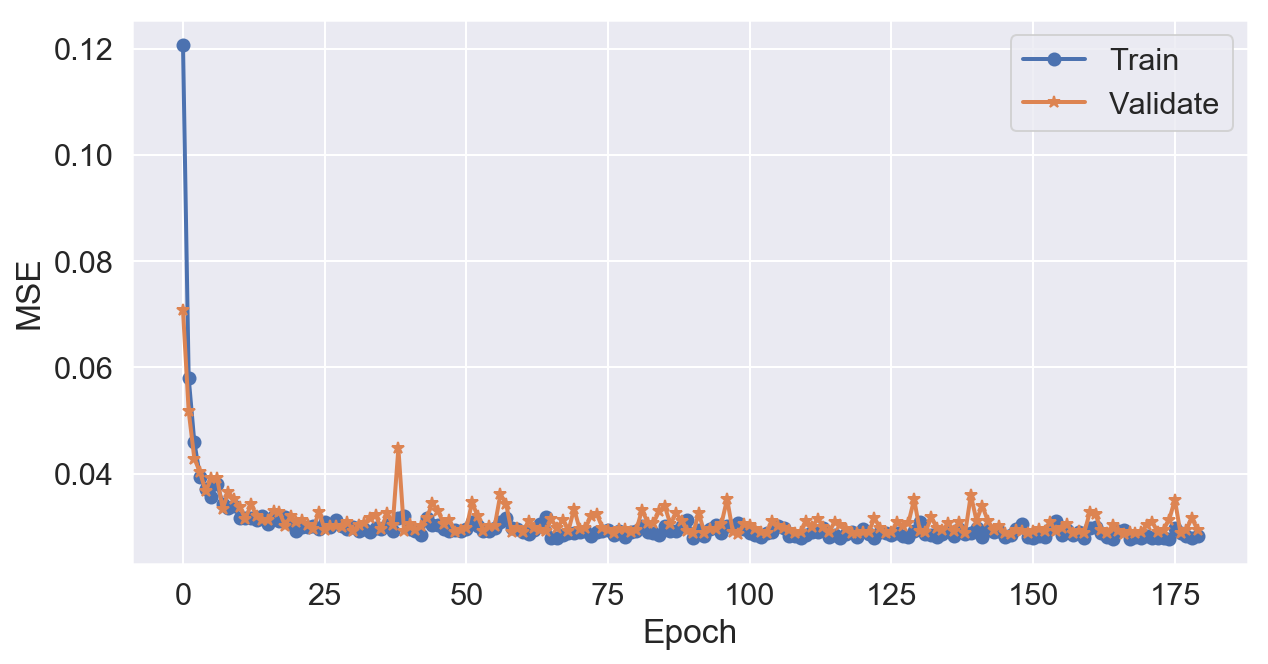

In [87]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],marker='o',linewidth=2)
plt.plot(history.history['val_loss'],marker='*',linewidth=2)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper right')
plt.show()

<font size="3">
Collect simulated results and measured data from test set in new dataframe
</font>

In [88]:
y_predict = model.predict(X_test)
y_predict_denormalize = inverse_transform(y_predict) 
y_test_denormalize = inverse_transform(y_test) 

dt_df = pd.DataFrame(buffer_time_test)
dt_df = dt_df.reset_index(drop=True)
dt_df = dt_df.rename(index=str, columns={"Time": "DateTime"})
dt_df['DateTime'] = pd.to_datetime(dt_df['DateTime'],dayfirst=True)

A_t= pd.DataFrame(buffer_target_t)
A_t = A_t.reset_index(drop=True)
A_t = A_t.rename(index=str, columns={"Target": "Measurement"})

result_matrix_T = pd.concat([dt_df, A_t], axis=1, join='inner')
result_matrix_T['DateTime'] = pd.to_datetime(result_matrix_T['DateTime'],dayfirst=True)
result_matrix_T.index = result_matrix_T['DateTime']
result_matrix_T = result_matrix_T.reset_index(drop=True)

y_train_rescale_df = pd.DataFrame(y_predict_denormalize)
y_train_rescale_df = y_train_rescale_df.reset_index()
y_train_rescale_df = y_train_rescale_df.drop(['index'],axis=1)
y_train_rescale_df = y_train_rescale_df.rename(index=str,columns={0: "Baseline",})
y_train_rescale_df = y_train_rescale_df.reset_index(drop=True)

result = pd.concat([result_matrix_T, y_train_rescale_df], axis=1, join='inner')
result['DateTime'] = pd.to_datetime(result['DateTime'],dayfirst=True)
result.index = result['DateTime']
result = result.reset_index(drop=True)
result.index = result['DateTime']
result = result.drop(['DateTime'],axis=1)
result

,Measurement,Baseline
DateTime,,
2018-03-12 22:00:00,0.0,0.0
2018-03-12 23:00:00,0.0,0.0
2018-03-13 00:00:00,0.0,0.0
2018-03-13 01:00:00,0.0,0.0
2018-03-13 02:00:00,0.0,0.0
2018-03-13 03:00:00,0.0,0.0
2018-03-13 04:00:00,0.0,0.0
...,...,...
2018-03-31 17:00:00,0.0,0.0


# Evaluation and verification in test set

<font size="3">
Evaluate the performance of deep learning model using:
<br.>
<br.>
$\mathrm{CV-RMSE} = \frac{\sqrt{\frac{1}{N} \sum_{i=1}^N (y_{i}-\widehat{y}_{i} )^2}}{\bar{y}}\times100$
<br.>
<br.>
$\mathrm{NMBE} =\frac{\sum_{i=1}^N (y_{i}-\widehat{y}_{i})}{N\times\bar{y}}\times100$
<br.>
<br.>
$\mathrm{R^2} = 1- \frac{\sum_{i=1}^N (y_{i}-\widehat{y}_{i})^2}{\sum_{i=1}^N (y_{i} - \bar{y})^2}$
<br.>
<br.>
where $N$ is the number of samples in the test set, $y_{i}$ and $\widehat{y}_{i}$ are measurement data and baseline results 
from deep learning model, respectively. $\bar{y}$ is the average of measured data. The lower values of $\mathrm{CV-RMSE}$ and 
$\mathrm{NMBE}$ indicate more accurate results. The higher value of $\mathrm{R^2}$ represents the higher correlation between 
the targeted and estimated outputs. 
<br.>
<br.>
<font color=darkorange>The estimated baseline is verified with the hourly baseline modeling standard</font>
</font> 

[View standard](https://www.researchgate.net/publication/26901656_ASHRAE's_Guideline_14-2002_for_Measurement_of_Energy_and_Demand_Savings_How_to_Determine_What_Was_Really_Saved_by_the_Retrofit)


In [89]:
a = df.loc[df['Target'] > 0]

RMSE = sqrt(mean_squared_error(result['Measurement'], result['Baseline']))

CVRMSE = (RMSE/a['Target'].mean())*100

MBE = (result['Measurement']-result['Baseline']).mean()

NMBE = (MBE/a['Target'].mean())*100
    
x = PrettyTable()

x.field_names = ["Performance indices", "Standard", "Results"]

x.add_row(["CV-RMSE (%)", 30, round(CVRMSE, 2)])
x.add_row(["NMBE (%)", 10, round(NMBE, 2)])
x.add_row(["R-Squared", 0.75, round(r2_score(result['Measurement'], result['Baseline']),2)])

print(x)

+---------------------+----------+---------+
| Performance indices | Standard | Results |
+---------------------+----------+---------+
|     CV-RMSE (%)     |    30    |  17.16  |
|       NMBE (%)      |    10    |   2.33  |
|      R-Squared      |   0.75   |   0.9   |
+---------------------+----------+---------+


# Example plots of the estimated AC power baseline

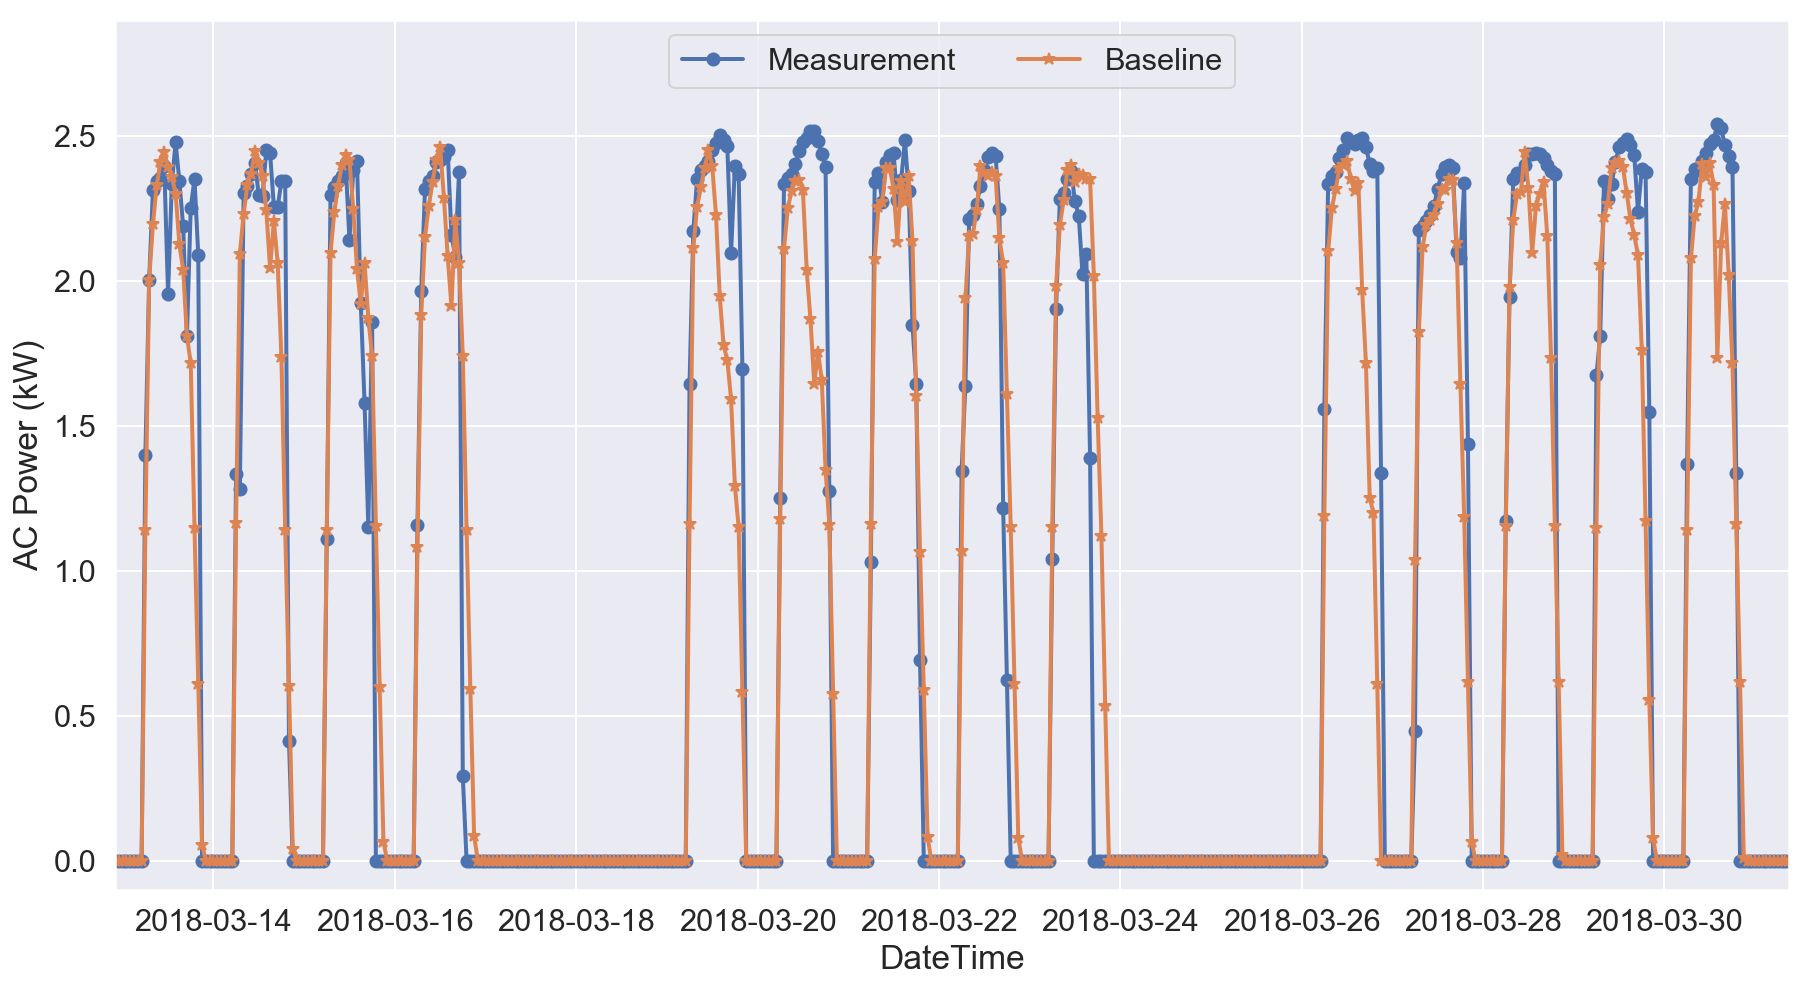

In [90]:
register_matplotlib_converters()
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(result.index, result['Measurement'],marker='o',linewidth=2,label='Measurement')
ax1.plot(result.index, result['Baseline'],marker='*',linewidth=2,label='Baseline')
ax1.legend(loc='upper center',ncol=4)
ax1.axis([result.index[0], result.index[-15],-0.1, 2.9])
ax1.set_ylabel('AC Power (kW)')
ax1.set_xlabel('DateTime')
ax1.grid(True)
plt.show()